Predict whether a user who views or adds a product to the cart will proceed to purchase it.

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import os
from pyspark.sql.functions import col, count, isnan, avg, max, row_number
from pyspark.sql.window import Window
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import when
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\anama\anaconda3\envs\Bigdata\Lib\site-packages\pyspark


In [25]:
python_path = os.environ.get('PYTHON_PATH')
app_name = os.environ.get('APP_NAME_DEC')
hadoop_path_dec = os.environ.get('HADOOP_DEC_DATASET_PATH')
hadoop_path_nov = os.environ.get('HADOOP_NOV_DATASET_PATH')
hadoop_path = os.environ.get('HADOOP_DATASET_PATH')

In [26]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '5g')\
    .set('spark.executor.memory', '5g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.dynamicAllocation.minExecutors', '1')
('spark.driver.port', '51141')
('spark.app.submitTime', '1703936666378')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.driver.host', 'BOOK-G6MUSCB12M.local')
('spark.executor.memory', '5g')
('spark.driver.memory', '5g')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=

In [27]:
df_dec = spark.read.csv(hadoop_path_dec+'/selected_Data/', header = True, inferSchema = True)
df_dec.show()

+------------+----------+----------+--------+-------+---------+------------+--------------------+---+
|          id|event_type|product_id|   brand|  price|  user_id|    category|             product|day|
+------------+----------+----------+--------+-------+---------+------------+--------------------+---+
|506806765360|      view|  28300254|   karya|  32.18|593496337|  appliances|       kitchen.grill| 27|
|171799589084|      view|   1004792|  xiaomi| 643.26|585940325| electronics|          smartphone| 12|
|223338714494|      view|   6701206|   palit| 257.92|517821395|  appliances|environment.air_h...| 15|
|438087353571|      view|  31200669|    ikea|   1.26|516126769| electronics|     audio.subwoofer| 24|
|146029038665|      view|   1801785|      lg| 396.38|532651693|  appliances|   personal.massager| 10|
| 77310004945|      view|   4400468|scarlett|  95.21|512989627|   computers|   components.cooler|  6|
| 94489852300|      view|   1004768| samsung| 228.71|583359020|construction|      

In [28]:
df_dec = df_dec.withColumn("month", lit(12))
df_dec.show()

+------------+----------+----------+--------+-------+---------+------------+--------------------+---+-----+
|          id|event_type|product_id|   brand|  price|  user_id|    category|             product|day|month|
+------------+----------+----------+--------+-------+---------+------------+--------------------+---+-----+
|506806765360|      view|  28300254|   karya|  32.18|593496337|  appliances|       kitchen.grill| 27|   12|
|171799589084|      view|   1004792|  xiaomi| 643.26|585940325| electronics|          smartphone| 12|   12|
|223338714494|      view|   6701206|   palit| 257.92|517821395|  appliances|environment.air_h...| 15|   12|
|438087353571|      view|  31200669|    ikea|   1.26|516126769| electronics|     audio.subwoofer| 24|   12|
|146029038665|      view|   1801785|      lg| 396.38|532651693|  appliances|   personal.massager| 10|   12|
| 77310004945|      view|   4400468|scarlett|  95.21|512989627|   computers|   components.cooler|  6|   12|
| 94489852300|      view|   

In [29]:
df_dec = df_dec.drop("id")
df_dec.show()

+----------+----------+--------+-------+---------+------------+--------------------+---+-----+
|event_type|product_id|   brand|  price|  user_id|    category|             product|day|month|
+----------+----------+--------+-------+---------+------------+--------------------+---+-----+
|      view|  28300254|   karya|  32.18|593496337|  appliances|       kitchen.grill| 27|   12|
|      view|   1004792|  xiaomi| 643.26|585940325| electronics|          smartphone| 12|   12|
|      view|   6701206|   palit| 257.92|517821395|  appliances|environment.air_h...| 15|   12|
|      view|  31200669|    ikea|   1.26|516126769| electronics|     audio.subwoofer| 24|   12|
|      view|   1801785|      lg| 396.38|532651693|  appliances|   personal.massager| 10|   12|
|      view|   4400468|scarlett|  95.21|512989627|   computers|   components.cooler|  6|   12|
|      view|   1004768| samsung| 228.71|583359020|construction|         tools.light|  7|   12|
|      view|   5000552|  jaguar|  75.27|536965230|

In [30]:
df_nov = spark.read.csv(hadoop_path_nov + '/selected_Data_Nov/', header = True, inferSchema = True)
df_nov.show()

+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|          id|event_type|product_id|     brand|  price|  user_id|   category|             product|day|
+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+
|403727064801|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|
| 42950433984|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|
| 34360364567|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|
|360777911454|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|
| 85900085278|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|
|180389410990|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|
| 17180281985|      view|   3900339|      aqua|  30.86|517565940| applian

In [31]:
df_nov = df_nov.withColumn("month", lit(11))
df_nov.show()

+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|          id|event_type|product_id|     brand|  price|  user_id|   category|             product|day|month|
+------------+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|403727064801|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|   11|
| 42950433984|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|   11|
| 34360364567|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|   11|
|360777911454|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|   11|
| 85900085278|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|   11|
|180389410990|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|   11|
| 17180281985|     

In [32]:
df_nov = df_nov.drop("id")
df_nov.show()

+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|event_type|product_id|     brand|  price|  user_id|   category|             product|day|month|
+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|   11|
|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|   11|
|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|   11|
|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|   11|
|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|   11|
|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|   11|
|      view|   3900339|      aqua|  30.86|517565940| appliances|environment.water...|  2|   11|
|      view|   1005233|    xiaomi| 150.5

In [33]:
df_combined = df_nov.union(df_dec)
df_combined.show()

+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|event_type|product_id|     brand|  price|  user_id|   category|             product|day|month|
+----------+----------+----------+-------+---------+-----------+--------------------+---+-----+
|      view|   1004239|     apple|1413.16|554666475|electronics|          smartphone| 18|   11|
|      view|   1004250|     apple| 741.04|527029321|electronics|          smartphone|  4|   11|
|      view|   1004886|      oppo| 128.67|543083998|electronics|          smartphone|  4|   11|
|      view|   1480156|       neo| 666.66|519293476|  computers|             desktop| 17|   11|
|      view|   6400162|     intel| 215.58|533512255|  computers|      components.cpu|  7|   11|
|      view|   1201284|    lenovo| 154.19|570911983|electronics|              tablet| 13|   11|
|      view|   3900339|      aqua|  30.86|517565940| appliances|environment.water...|  2|   11|
|      view|   1005233|    xiaomi| 150.5

In [34]:
save_path = hadoop_path + '/combined_Data/' 

df_combined.repartition(8).write.mode('overwrite').option("header", "true").csv(save_path)


In [35]:
df = spark.read.csv(hadoop_path + '/combined_Data/', header = True, inferSchema = True)
df.show()

+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
|event_type|product_id|  brand|  price|  user_id|   category|             product|day|month|
+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
|      view|   3600661|samsung| 308.86|572466808| appliances|      kitchen.washer| 17|   11|
|      view|   1005136|  apple|2007.52|518751528|electronics|          smartphone| 14|   11|
|      view|   1401577|  apple| 1441.2|520999069|  computers|             desktop| 23|   11|
|      view|   1005159| xiaomi| 200.39|517708505|electronics|          smartphone| 21|   11|
|      cart|   1004766|samsung| 251.82|523183378|electronics|          smartphone| 22|   11|
|      view| 100003580| optima| 193.03|519133244| appliances|kitchen.refrigera...| 15|   11|
|      view|   1801226|  yasin| 115.75|568638630|electronics|            video.tv| 20|   11|
|      view|   1004858|samsung|  126.0|516835814|electronics|         

In [36]:
df_index = df.select('*').withColumn('id', F.monotonically_increasing_id())
column_names = ['id'] + [col for col in df.columns]

df_index_first = df_index.select(column_names)
df_index_first.show()

+---+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
| id|event_type|product_id|  brand|  price|  user_id|   category|             product|day|month|
+---+----------+----------+-------+-------+---------+-----------+--------------------+---+-----+
|  0|      view|   3600661|samsung| 308.86|572466808| appliances|      kitchen.washer| 17|   11|
|  1|      view|   1005136|  apple|2007.52|518751528|electronics|          smartphone| 14|   11|
|  2|      view|   1401577|  apple| 1441.2|520999069|  computers|             desktop| 23|   11|
|  3|      view|   1005159| xiaomi| 200.39|517708505|electronics|          smartphone| 21|   11|
|  4|      cart|   1004766|samsung| 251.82|523183378|electronics|          smartphone| 22|   11|
|  5|      view| 100003580| optima| 193.03|519133244| appliances|kitchen.refrigera...| 15|   11|
|  6|      view|   1801226|  yasin| 115.75|568638630|electronics|            video.tv| 20|   11|
|  7|      view|   1004858|sam

In [37]:
df = df_index_first.withColumn("is_purchased", when(df["event_type"] == "purchase", 1).otherwise(0))

In [38]:
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
encoder = OneHotEncoder(inputCols=["categoryIndex"], outputCols=["categoryVec"])
assembler = VectorAssembler(inputCols=["categoryVec", "price", "day","month"], outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="is_purchased")

In [39]:
pipeline = Pipeline(stages=[indexer, encoder, assembler, scaler, lr])

In [40]:
(train, test) = df.randomSplit([0.8, 0.2])

In [41]:
model = pipeline.fit(train)

In [42]:
transformed_data = model.transform(test)

transformed_data.show(truncate=False)


+---+----------+----------+-------+-------+---------+------------+----------------------+---+-----+------------+-------------+--------------+-----------------------------------------+-----------------------------------------------------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|id |event_type|product_id|brand  |price  |user_id  |category    |product               |day|month|is_purchased|categoryIndex|categoryVec   |features                                 |scaledFeatures                                                                                 |rawPrediction                           |probability                              |prediction|
+---+----------+----------+-------+-------+---------+------------+----------------------+---+-----+------------+-------------+--------------+-----------------------------------------+---------------------------------------------------------------------

In [43]:
predictions = model.transform(test)

In [44]:
evaluator = BinaryClassificationEvaluator(labelCol="is_purchased")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)

Accuracy:  0.6075400179634016


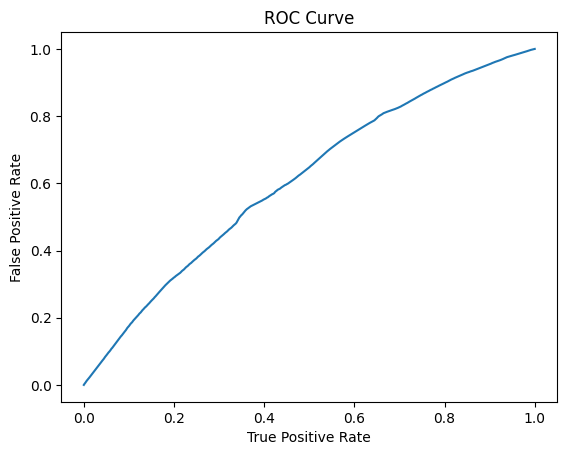

Training set areaUnderROC: 0.6081499926928893


In [57]:
trainingSummary = model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

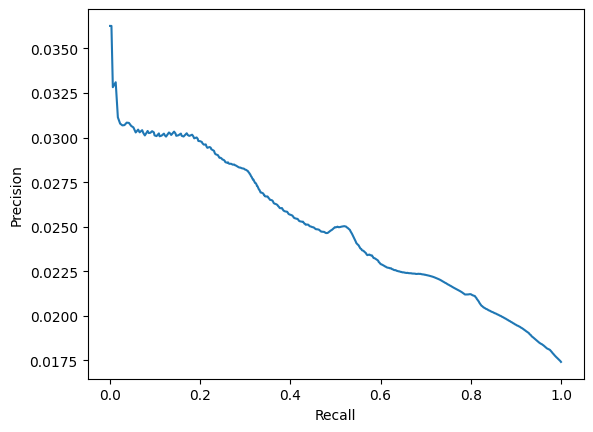

In [58]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

 Predict the likelihood of a user preferring a specific brand

In [ ]:
brand_interaction_count = df.groupBy("user_id", "brand").count().withColumnRenamed("count", "interaction_count")
brand_interaction_count.show()

+---------+-----------+-----------------+
|  user_id|      brand|interaction_count|
+---------+-----------+-----------------+
|572466808|    samsung|               11|
|519048171|    samsung|               25|
|514781092|      bayer|                1|
|568914039|      razer|                7|
|545668384|      apple|               20|
|523507259|    samsung|                3|
|571853173|     thomas|                9|
|556616265|      legre|                2|
|565342189|      apple|               32|
|520563628|     huawei|                9|
|517583596|     lenovo|               22|
|577488590|    karcher|                9|
|526730807|         bq|                2|
|578245775|   autoline|                2|
|514419099|      delux|                2|
|534511379|      bosch|               11|
|514987226|      apple|              127|
|568667424|plantronics|                7|
|518855693|      apple|               52|
|515817168|         sv|               17|
+---------+-----------+-----------

In [ ]:
brand_purchase_count = df.filter(col("event_type") == "purchase").groupBy("user_id", "brand").count().withColumnRenamed("count", "purchase_count")
brand_purchase_count.show()

+---------+--------+--------------+
|  user_id|   brand|purchase_count|
+---------+--------+--------------+
|574100819|   honor|             2|
|567726905| samsung|             1|
|569893776|   apple|             7|
|571776964|  xiaomi|             1|
|516781900| samsung|             1|
|514115418|   apple|            17|
|547625107|   apple|             3|
|564929325| samsung|             7|
|518329681| samsung|             3|
|516055995|    asus|             6|
|567411597| samsung|             1|
|516491883|  xiaomi|             1|
|537587201| element|             6|
|516363526|elenberg|             1|
|565961604| samsung|            15|
|560417238| samsung|             7|
|514550893|   apple|             4|
|558952612|    acer|             2|
|512896694|  bosher|             2|
|553306800|    zeta|             1|
+---------+--------+--------------+
only showing top 20 rows



In [ ]:
# Join interaction count back to the original DataFrame
df = df.join(brand_interaction_count, ["user_id", "brand"], "left")

# Join purchase count back to the original DataFrame
df = df.join(brand_purchase_count, ["user_id", "brand"], "left")

df.show()

+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+
|  user_id|     brand|          id|event_type|product_id| price|    category|             product|day|month|is_purchased|interaction_count|purchase_count|
+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+
|469154355|    xiaomi|171798691854|      view|   1004792|478.26| electronics|          smartphone|  4|   11|           0|               18|             1|
|512504927|sportelite|154618822665|      view|  27000040| 361.4|       sport|             trainer| 28|   12|           0|               23|          null|
|512564822|    rieker|214748364811|      view|  28721092|106.31|     apparel|               shoes| 25|   11|           0|               60|             1|
|513221934|   samsung| 25769803794|      view|   3601344|424.46|  appl

In [ ]:
df = df.na.fill({'purchase_count': 0})

In [ ]:
avg_price_interaction = df.groupBy("user_id", "brand").agg(avg("price").alias("avg_price_per_brand"))
df = df.join(avg_price_interaction, ["user_id", "brand"], "left")
df.show()

+---------+--------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+
|  user_id|   brand|          id|event_type|product_id| price|    category|             product|day|month|is_purchased|interaction_count|purchase_count|avg_price_per_brand|
+---------+--------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+
|469154355|  xiaomi|171798691854|      view|   1004792|478.26| electronics|          smartphone|  4|   11|           0|               18|             1|  447.6044444444444|
|513333263|   popov|360777252873|      view|  16800177|151.87|  appliances|kitchen.refrigera...| 11|   12|           0|               22|             0| 114.54045454545454|
|513994701|  lenovo|          18|      view|   1201479|306.06| electronics|              tablet| 15|   11|           0|                

In [ ]:
recency_interaction = df.groupBy("user_id", "brand").agg(max("day").alias("last_interaction_day"))
df = df.join(recency_interaction, ["user_id", "brand"], "left")
df.show()

+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+
|  user_id|     brand|          id|event_type|product_id| price|    category|             product|day|month|is_purchased|interaction_count|purchase_count|avg_price_per_brand|last_interaction_day|
+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+
|469154355|    xiaomi|171798691854|      view|   1004792|478.26| electronics|          smartphone|  4|   11|           0|               18|             1|  447.6044444444444|                   4|
|513333263|     popov|360777252873|      view|  16800177|151.87|  appliances|kitchen.refrigera...| 11|   12|           0|               22|             0| 114.54045454545454|                  21|
|516204782|      gew

In [ ]:
df = df.na.fill({
    'purchase_count': 0,
    'interaction_count': 0,
    'avg_price_per_brand': 0,
    "last_interaction_day":0
})
df.show()

+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+
|  user_id|     brand|          id|event_type|product_id| price|    category|             product|day|month|is_purchased|interaction_count|purchase_count|avg_price_per_brand|last_interaction_day|
+---------+----------+------------+----------+----------+------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+
|469154355|    xiaomi|171798691854|      view|   1004792|478.26| electronics|          smartphone|  4|   11|           0|               18|             1|  447.6044444444444|                   4|
|513333263|     popov|360777252873|      view|  16800177|151.87|  appliances|kitchen.refrigera...| 11|   12|           0|               22|             0| 114.54045454545454|                  21|
|516204782|      gew

In [ ]:
# Encode categorical variables
brand_indexer = StringIndexer(inputCol="brand", outputCol="brandIndex")
df = brand_indexer.fit(df).transform(df)
encoder = OneHotEncoder(inputCols=["brandIndex"], outputCols=["brandVec"])
df = encoder.fit(df).transform(df)
df.show()

+---------+---------+------------+----------+----------+------+------------+------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+----------+------------------+
|  user_id|    brand|          id|event_type|product_id| price|    category|           product|day|month|is_purchased|interaction_count|purchase_count|avg_price_per_brand|last_interaction_day|brandIndex|          brandVec|
+---------+---------+------------+----------+----------+------+------------+------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+----------+------------------+
| 86517859|    tefal| 77309439831|      view|  15900313|  8.98|construction|   tools.generator|  6|   12|           0|                1|             0|               8.98|                   6|      20.0| (4289,[20],[1.0])|
|170313967|moldabela| 60131466975|      view|  28100851|170.66|     apparel|           pajamas| 19|   12|   

In [59]:
save_path = hadoop_path_dec + '/SpecificBrand_Data/' 

df.repartition(8).write.mode('overwrite').option("header", "true").parquet(save_path)


In [ ]:
df = spark.read.parquet(hadoop_path_dec + '/SpecificBrand_Data/', header = True, inferSchema = True)
df.show()

+---------+--------------+------------+----------+----------+-------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+----------+----------------+
|  user_id|         brand|          id|event_type|product_id|  price|    category|             product|day|month|is_purchased|interaction_count|purchase_count|avg_price_per_brand|last_interaction_day|brandIndex|        brandVec|
+---------+--------------+------------+----------+----------+-------+------------+--------------------+---+-----+------------+-----------------+--------------+-------------------+--------------------+----------+----------------+
|556580998|        lenovo|309238069723|      view|   1307004| 290.61|   computers|            notebook| 16|   11|           0|                4|             0|           317.4325|                  16|       6.0|(4289,[0],[0.0])|
|574029906|       lucente|188980303225|      view|  26300189|  351.1|  appliances|ki

In [ ]:
# Assemble all features
assembler = VectorAssembler(
    inputCols=[
        "interaction_count",
        "purchase_count",
        "avg_price_per_brand",
        "brandVec",
        "last_interaction_day",
        "day",  
        "month" 
    ],
    outputCol="features"
)
df = assembler.transform(df)

In [ ]:
windowSpec = Window.partitionBy("user_id").orderBy(col("purchase_count").desc())

# Add a row number for each user based on purchase count (highest purchase count gets row_number = 1)
df = df.withColumn("preference_rank", row_number().over(windowSpec))

# Define the target variable as 1 for the most preferred brand, 0 otherwise
df = df.withColumn("label", when(col("preference_rank") == 1, 1).otherwise(0))

In [ ]:
df.show()

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)

model = rf.fit(train)


In [ ]:
predictions = model.transform(test)

In [ ]:
# Evaluate model using Area Under ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print("Area Under ROC: ", roc_auc)

Area Under ROC:  0.5005018271511746


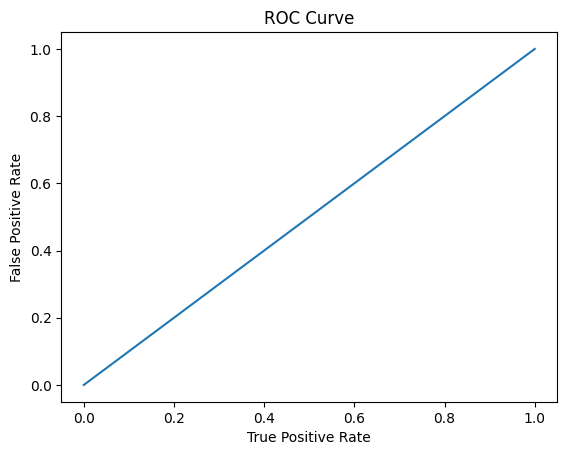

In [ ]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()